## Procesamiento de datos
En este notebook se hará un nuevo procesado a los datos de train y test

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
%%time
df = pd.read_csv('data/train_ver2.csv',
                 dtype={'sexo': str, 'age': str, 'ind_nuevo': str, 'indrel_1mes': str, 
                        'antiguedad': str, 'ult_fec_cli_lt': str, 'indext': str, 'conyuemp': str},
                 parse_dates=['fecha_dato', 'fecha_alta'])
df.head()

CPU times: user 2min 49s, sys: 11.3 s, total: 3min
Wall time: 3min


In [3]:
%%time
df_test = pd.read_csv('data/test_ver2.csv',
                 dtype={'sexo': str, 'age': str, 'ind_nuevo': str, 'indrel_1mes': str, 
                        'antiguedad': str, 'ult_fec_cli_lt': str, 'indext': str, 'conyuemp': str},
                 parse_dates=['fecha_dato', 'fecha_alta'])
df_test.head()

CPU times: user 5.04 s, sys: 88 ms, total: 5.12 s
Wall time: 5.12 s


In [5]:
df.shape, df_test.shape

((13647309, 48), (929615, 24))

Eliminación de columnas con valores llenos de *NaN*

In [6]:
df.drop(labels=['conyuemp', 'ult_fec_cli_1t'], inplace=True, axis=1)

### Reemplazo de renta
Se reemplazarán los valores faltantes de renta con la media que haya en cada provincia y según el segmento al que pertenezca el cliente

In [7]:
renta_by_seg = df.groupby(['nomprov', 'segmento']).agg({'renta' : 'mean'})
renta_by_seg.iloc[:6]

renta
nomprov  segmento                         
ALAVA    01 - TOP             55271.070000
         02 - PARTICULARES   145173.240000
         03 - UNIVERSITARIO   89039.301429
ALBACETE 01 - TOP             90440.961226
         02 - PARTICULARES    85873.202656
         03 - UNIVERSITARIO   81308.387749

In [8]:
renta_by_seg = renta_by_seg.loc[:, ['renta']].round(2)
renta_by_seg.iloc[:6]

renta
nomprov  segmento                     
ALAVA    01 - TOP             55271.07
         02 - PARTICULARES   145173.24
         03 - UNIVERSITARIO   89039.30
ALBACETE 01 - TOP             90440.96
         02 - PARTICULARES    85873.20
         03 - UNIVERSITARIO   81308.39

In [9]:
%%time
for i in renta_by_seg.index:
    renta_value = renta_by_seg.loc[i, 'renta']
    df.loc[(df['nomprov'] == i[0]) & (df['segmento'] == i[1]) & (df['renta'].isnull()), 'renta'] = renta_value

CPU times: user 5min 55s, sys: 264 ms, total: 5min 55s
Wall time: 5min 55s


### Valores faltantes después de llenar las filas de "renta". Se procede a eliminar esas filas que sólo representan cerca del 1.9% del dataset, y ese tamaño no es significativo

In [10]:
missing = df[df.isnull().any(axis=1)]
missing.shape[0]/df.shape[0]

0.01900396627642856

In [10]:
missing_sum = df.isnull().sum().sort_values(ascending=False)
missing_sum = missing_sum[missing_sum > 0]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

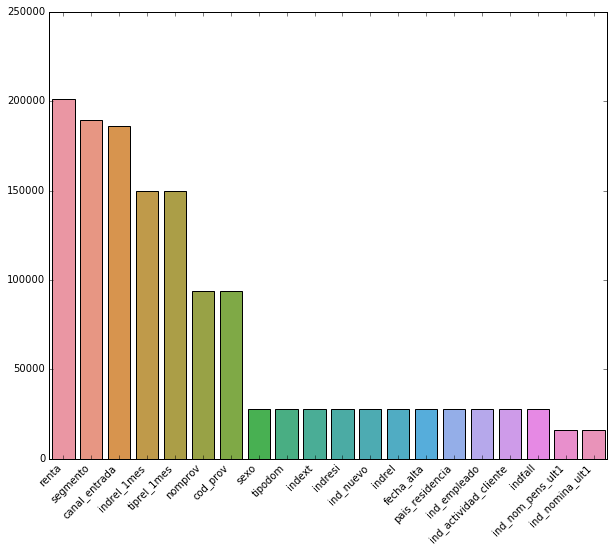

In [11]:
plt.figure(figsize=(10, 8))
sns.barplot(missing_sum[missing_sum > 0].index, missing_sum[missing_sum > 0].values)
plt.xticks(rotation=45, ha='right')

#### Registros ANTES de eliminar las filas anteriores

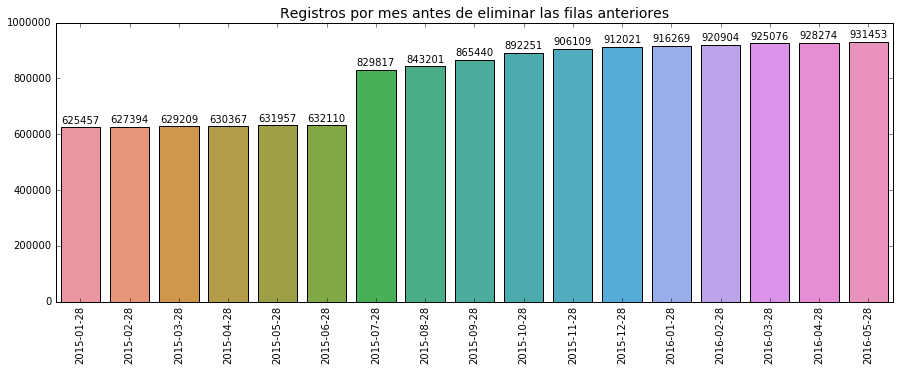

In [12]:
dates = df.fecha_dato.value_counts().sort_index()
fecha_dato = [str(date).split()[0] for date in dates.index]
count_dates = dates.values

plt.figure(figsize=(15, 5))
sns.barplot(fecha_dato, count_dates)
plt.xticks(rotation='vertical')
plt.title('Registros por mes antes de eliminar las filas anteriores', size=14)

for i, count in enumerate(count_dates):
    plt.text(i, count*1.01, count, ha='center', va='bottom')

#### Eliminar filas

In [11]:
df.drop(missing.index, inplace=True, axis=0)
df.shape

(13387956, 46)

#### Registros DESPUÉS de eliminar las filas anteriores

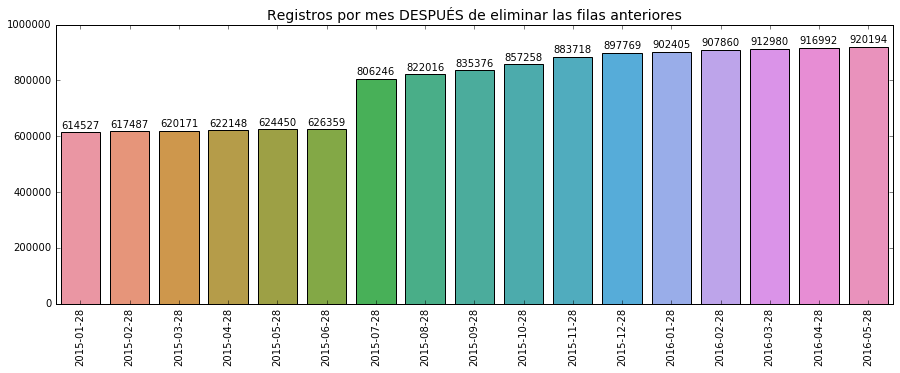

In [14]:
dates = df.fecha_dato.value_counts().sort_index()
fecha_dato = [str(date).split()[0] for date in dates.index]
count_dates = dates.values

plt.figure(figsize=(15, 5))
sns.barplot(fecha_dato, count_dates)
plt.xticks(rotation='vertical')
plt.title('Registros por mes DESPUÉS de eliminar las filas anteriores', size=14)

for i, count in enumerate(count_dates):
    plt.text(i, count*1.01, count, ha='center', va='bottom')

#### Cambio de tipos de variables 

In [12]:
df[['ind_nomina_ult1', 'ind_nom_pens_ult1']] = df[['ind_nomina_ult1', 'ind_nom_pens_ult1']].astype('int64')
df['age'] = df['age'].astype('int64')
df['ind_nuevo'] = df['ind_nuevo'].astype('int64')
df['antiguedad'] = df['antiguedad'].astype('int64')
df['indrel_1mes'] = df['indrel_1mes'].astype('float64')

#### División de fechas

In [13]:
df['fecha_dato_year'] = df.fecha_dato.dt.year
df['fecha_dato_month'] = df.fecha_dato.dt.month
df['fecha_dato_day'] = df.fecha_dato.dt.day

df['fecha_alta_year'] = df.fecha_alta.dt.year
df['fecha_alta_month'] = df.fecha_alta.dt.month
df['fecha_alta_day'] = df.fecha_alta.dt.day

In [14]:
df_cols = df.columns.tolist()
df_cols_reordered = df_cols[:1] + df_cols[46:49] + df_cols[1:7] + df_cols[49:52] + df_cols[7:46]

In [15]:
df = df[df_cols_reordered]
df.head()

,fecha_dato,fecha_dato_year,fecha_dato_month,fecha_dato_day,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,2015,1,28,1375586,N,ES,H,35,2015-01-12,...,0,0,0,0,0,0,0,0,0,0
1,2015-01-28,2015,1,28,1050611,N,ES,V,23,2012-08-10,...,0,0,0,0,0,0,0,0,0,0
2,2015-01-28,2015,1,28,1050612,N,ES,V,23,2012-08-10,...,0,0,0,0,0,0,0,0,0,0
3,2015-01-28,2015,1,28,1050613,N,ES,H,22,2012-08-10,...,0,0,0,0,0,0,0,0,0,0
4,2015-01-28,2015,1,28,1050614,N,ES,V,23,2012-08-10,...,0,0,0,0,0,0,0,0,0,0


### División de dataset entre datos `(X)` y targets `(y)`
#### Targets

In [20]:
targets = df.loc[:, 'ind_ahor_fin_ult1':]
targets.shape

(13387956, 24)

In [21]:
targets.head()

,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
targets.to_csv('data/clean/train_labels.csv', index=False)

#### Datos

In [16]:
df = df.loc[:, :'segmento']
df.shape

(13387956, 28)

In [17]:
df.head()

,fecha_dato,fecha_dato_year,fecha_dato_month,fecha_dato_day,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,...,indresi,indext,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento
0,2015-01-28,2015,1,28,1375586,N,ES,H,35,2015-01-12,...,S,N,KHL,N,1.0,29.0,MALAGA,1.0,87218.10,02 - PARTICULARES
1,2015-01-28,2015,1,28,1050611,N,ES,V,23,2012-08-10,...,S,S,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.74,03 - UNIVERSITARIO
2,2015-01-28,2015,1,28,1050612,N,ES,V,23,2012-08-10,...,S,N,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.11,03 - UNIVERSITARIO
3,2015-01-28,2015,1,28,1050613,N,ES,H,22,2012-08-10,...,S,N,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.54,03 - UNIVERSITARIO
4,2015-01-28,2015,1,28,1050614,N,ES,V,23,2012-08-10,...,S,N,KHE,N,1.0,50.0,ZARAGOZA,1.0,110927.09,03 - UNIVERSITARIO


#### Cambio de variables categóricas a numéricas

In [18]:
cols_object = df.select_dtypes(['object']).columns

In [20]:
cols_object

Index(['ind_empleado', 'pais_residencia', 'sexo', 'tiprel_1mes', 'indresi',
       'indext', 'canal_entrada', 'indfall', 'nomprov', 'segmento'],
      dtype='object')

In [ ]:
%%time
for col in cols_object:
    attribute_vals = df[col].value_counts().index
    attribute_counts = np.arange(1, len(attribute_vals) + 1)
    df.replace(attribute_vals, attribute_counts, inplace=True)
    print(col, '¡LISTO!')

In [ ]:
df.to_csv('data/clean/train_clean.csv', index=False)

---
### Correción de división de *fecha_dato*

In [13]:
df = pd.read_csv('data/clean/train_clean.csv')

In [14]:
df.head()

,fecha_dato,fecha_dato_year,fecha_dato_month,fecha_dato_day,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,...,indresi,indext,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento
0,2015-01-28,2015,1,28,1375586,1,1,1,35,2015-01-12,...,2,1,19,1,1.0,29.0,7,1.0,87218.10,1
1,2015-01-28,2015,1,28,1050611,1,1,1,23,2012-08-10,...,2,2,1,1,1.0,13.0,25,0.0,35548.74,2
2,2015-01-28,2015,1,28,1050612,1,1,1,23,2012-08-10,...,2,1,1,1,1.0,13.0,25,0.0,122179.11,2
3,2015-01-28,2015,1,28,1050613,1,1,1,22,2012-08-10,...,2,1,9,1,1.0,50.0,8,0.0,119775.54,2
4,2015-01-28,2015,1,28,1050614,1,1,1,23,2012-08-10,...,2,1,1,1,1.0,50.0,8,1.0,110927.09,2


In [15]:
%%time
df.loc[:, 'fecha_dato_year'] = list(map(lambda x: int(x.split('-')[0]), df.loc[:, 'fecha_dato'].values))
df.loc[:, 'fecha_dato_month'] = list(map(lambda x: int(x.split('-')[1]), df.loc[:, 'fecha_dato'].values))
df.loc[:, 'fecha_dato_day'] = list(map(lambda x: int(x.split('-')[2]), df.loc[:, 'fecha_dato'].values))

CPU times: user 1min 8s, sys: 200 ms, total: 1min 8s
Wall time: 1min 8s


In [18]:
%%time
df.to_csv('data/clean/train_clean.csv', index=False)

CPU times: user 8min 12s, sys: 1.66 s, total: 8min 13s
Wall time: 8min 22s
